In [1]:
# import sys
# sys.path.append("../../")
import libspn as spn
import numpy as np
import tensorflow as tf

In [2]:
num_decomps = 2
num_subsets = 2
num_input_mixtures = 2
num_roots = 1
num_mixtures = 2
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.MIXTURE

# Additive smoothing during learning
additive_smoothing=10
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(1, 1)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

In [3]:
male_data = []
male_labels = np.concatenate([np.ones(330) * i for i in range(10)])
female_data = []
female_labels = np.concatenate([np.ones(330) * i for i in range(10)])
with open('/home/jos/data/arabic/Train_Arabic_Digit.txt') as f:
    count = 0
    block = []
    for line in f.readlines():
        words = line.split(' ')
        if len(words) == 13 and all(words):
            block.append([float(w) for w in words])
        else:
            if block:
                if (count // 330) % 2 == 0:
                    male_data.append(block)
                else:
                    female_data.append(block)
            count += 1
            block = []
    if block:
        female_data.append(block)
            
# import pandas as pd

# train_data = pd.read_csv('/home/jos/datasets/arabic/pendigits.tra', delimiter=',', header=None)

In [4]:
all_data = male_data + female_data


In [5]:
def sequence_lens(sequences):
    return [len(seq) for seq in sequences]

def pad_sequences(sequences, sequence_maxlen, padding_val=-1):
    ret = []
    for seq in sequences:
        arr = np.asarray(seq)
        ret.append(np.concatenate([
            padding_val * np.ones((sequence_maxlen - len(seq),) + arr.shape[1:]),
            arr
        ]))
    return np.asarray(ret)



In [6]:
data_stacked = np.concatenate(all_data, axis=0)
print(data_stacked.shape)
padded = pad_sequences(all_data[:2], 93)

(263256, 13)


In [7]:
seq_lens = np.asarray(sequence_lens(all_data))
X = pad_sequences(all_data, 93)
y = np.expand_dims(np.concatenate([male_labels, female_labels]), 1)
print(X.shape)

(6600, 93, 13)


As you can see the dataset is perfectly balanced.

/home/jos/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


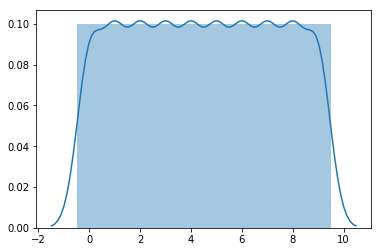

In [8]:
%matplotlib inline
import seaborn as sns
sns.distplot(y, bins=np.arange(-0.5, 10))

In [9]:
tf.reset_default_graph()
dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                            input_dist=input_dist, num_input_mixtures=num_input_mixtures, 
                                            node_type=spn.DenseSPNGeneratorLayerNodes.NodeType.LAYER)



contvars = spn.GaussianLeaf(
    max_steps=93, num_vars=13, num_components=4, data=data_stacked, dynamic=True, use_prior=False,
    learn_dist_params=True, total_counts_init=100, min_stddev=1e-8)

top_per_digit = []
for d in range(10):
    root = dense_gen.generate(contvars)
#     print(root.values[0].node)
    template_head = root.values[0].node
    
    interface = spn.DynamicInterface(name="Interface")
    interface.set_source(template_head)
    
    interface_mixtures = spn.ParSums(interface, num_sums=template_head.num_prods, name="InterfaceMixtures", interface_head=True)
    
    prod_sizes = template_head.num_or_size_prods
    offset = 0
    new_inputs, new_prod_sizes = [], []
    for i, size in enumerate(prod_sizes):
        new_inputs.extend(template_head.inputs[offset:offset+size])
        new_inputs.append(spn.Input(node=interface_mixtures, indices=i))
        new_prod_sizes.append(size + 1)
        offset += size
    template_head.set_values(*new_inputs)
    template_head.set_prod_sizes(new_prod_sizes)
    
    top_per_digit.append(root)
    #     top_per_digit.append(spn.Sum(*template_heads, name="Top{}".format(d)))
    
root = spn.Sum(*top_per_digit)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()

print(root.get_num_nodes())


174


In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
sequence_len_ph = tf.placeholder(tf.int32, [None])
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var, sequence_lens=sequence_len_ph,
                          initial_accum_value=100)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood = learning.likelihood()
avg_train_likelihood = tf.reduce_mean(train_likelihood)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:491: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:497: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use the `axis` argument instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/graph/sum.py:299: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


In [13]:
print(seq_lens.shape, X.shape, y.shape)

(6600,) (6600, 93, 13) (6600, 1)


In [11]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE, dynamic=True)
mpe_ivs, mpe_latent = mpe_state_gen.get_state(root, contvars, latent)

In [12]:
sess = None
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [13]:
K = 10
kf = KFold(n_splits=K)
num_batches = 8
num_epochs = 15
shuffle_data = True

test_likelihood = np.zeros((K, num_epochs + 1))
test_likelihood_labels = np.zeros((K, num_epochs + 1))
test_classification = np.zeros((K, num_epochs + 1))
train_likelihood = np.zeros((K, num_epochs, num_batches))

    
for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X[train_index].transpose((1, 0, 2))
    y_train = y[train_index]
    seq_len_train = seq_lens[train_index]
    
    X_test = X[test_index].transpose((1, 0, 2))
    y_test = y[test_index]
    seq_len_test = seq_lens[test_index]
    
    batch_size = X_train.shape[1] // num_batches
    
    if sess is not None:
        sess.close()
    sess = tf.Session()

    sess.run(init_weights)
    sess.run(reset_accumulators)

    prev_likelihood = 100
    likelihood = 0
    for epoch in range(num_epochs):
        prev_likelihood=likelihood
        likelihoods = []
        pbar = tqdm_notebook(range(num_batches))
        if shuffle_data:
            X_train, y_train, seq_len_train = shuffle(
                X_train.transpose((1, 0, 2)), y_train, seq_len_train)
            X_train = X_train.transpose((1, 0, 2))

        test_fd = {contvars: X_test, latent: np.ones((X_test.shape[1], 1))*-1,sequence_len_ph: seq_len_test}
        y_hat_test = sess.run(mpe_latent, feed_dict=test_fd)
        test_classification[k, epoch] = np.mean(y_hat_test[-1] == y_test)
        test_likelihood[k, epoch] = sess.run(avg_train_likelihood, feed_dict=test_fd)
        test_fd[latent] = y_test
        test_likelihood_labels[k, epoch] = sess.run(avg_train_likelihood, feed_dict=test_fd)


        for i, batch in enumerate(pbar):
            start = (batch)*batch_size
            stop = (batch+1)*batch_size
            # Adjust smoothing
            ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
            sess.run(additive_smoothing_var.assign(ads))
            # Run accumulate_updates
            avg_train_likelihood_val, _, = \
                    sess.run([avg_train_likelihood, accumulate_updates], 
                             feed_dict={contvars: X_train[:, start:stop],
                                       latent: y_train[start:stop],
                                       sequence_len_ph: seq_len_train[start:stop]})
            # Print avg likelihood of this batch data on previous batch weights
            likelihoods.append(avg_train_likelihood_val)
            train_likelihood[k, epoch, i] = avg_train_likelihood_val
            pbar.set_description("lh: {}".format(avg_train_likelihood_val))
            # Update weights
        sess.run(update_spn)
        likelihood = sum(likelihoods) / len(likelihoods)
        print("Avg likelihood: %s" % (likelihood))
        if epoch + 1 % 5 == 0:
            sess.run(reset_accumulators)

    test_fd = {contvars: X_test, latent: np.ones((X_test.shape[1], 1))*-1,sequence_len_ph: seq_len_test}
    y_hat_test = sess.run(mpe_latent, feed_dict=test_fd)
    test_classification[k, num_epochs] = np.mean(y_hat_test[-1] == y_test)
    test_likelihood[k, num_epochs] = sess.run(avg_train_likelihood, feed_dict=test_fd)
    test_fd[latent] = y_test
    test_likelihood_labels[k, num_epochs] = sess.run(avg_train_likelihood, feed_dict=test_fd)





Avg likelihood: -757.893180847168



Avg likelihood: -723.1368026733398



Avg likelihood: -710.2462310791016



Avg likelihood: -696.2178344726562



Avg likelihood: -685.6963043212891



Avg likelihood: -678.1603012084961



Avg likelihood: -672.1075286865234



Avg likelihood: -667.0933380126953


KeyboardInterrupt: 